## Import

In [1]:
!python _notebook2script.py --allFiles -q

In [2]:
#export
from exp.Data import get_datasets, get_dataloaders, get_data_transforms, get_mean_std_per_channel, get_class_counts
from exp.Sampler import get_samplers
from exp.Model import get_model
from exp.Hyperparameter import get_criterion, get_optimizer, get_scheduler, run_lr_finder
from exp.Training import get_device, one_episode, one_epoch, one_batch
from exp.Prediction import get_pred_class_function, get_pred_dict
from exp.Metrics import get_metrics, MetricUpdates
from exp.Util import imshow, show_dl_images

from datetime import datetime
import json
import os
import sys
import torch
import importlib
from tqdm.auto import tqdm

## God Class

In [3]:
#export
class GodClass():
    version = 0.1
    
    def __init__(self, config_dict=None, config_json=None, config_py=None):
        self.load_config(config_dict, config_json, config_py)
        
        self.data_transforms = get_data_transforms(self)
        self.datasets = get_datasets(self)
        self.samplers = get_samplers(self)
        self.dataloaders = get_dataloaders(self)
        self.device = get_device(self)
        
        self.pred_class_function = get_pred_class_function(self)
        self.metrics_results = {}
        self.metrics, self.multi_epoch_metrics = get_metrics(self)
        self.state = {'episode_nr': 0}
        
        self.load_setup()
                
        
    def load_config(self, config_dict, config_json, config_py):
        if config_dict:
            self.config = config_dict
        elif config_json:
            self.config = json.load(config_json)
        elif config_py:
            config_file_path = os.path.abspath(config_py)
            config_module_name = os.path.splitext(os.path.basename(config_py))[0]

            spec = importlib.util.spec_from_file_location(config_module_name, config_file_path)
            if spec is None:
                raise ImportError(f"Unable to load module from file: '{config_file_path}'")

            config_module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(config_module)

            self.config = config_module.CONFIG
        else: 
            raise Exception('Must either provide config_dict, config_json or config_py')        
        
    def load_setup(self, custom_lr=None):
        self.model = get_model(self)
        self.criterion = get_criterion(self)
        self.optimizer = get_optimizer(self, custom_lr=custom_lr)
        self.scheduler = get_scheduler(self)
    
    
    def run_episodes(self, n_episodes):
        use_progress_bar = self.config['training']['output'].get('progress_bar', {}).get('episode', False)
        for _ in tqdm(range(n_episodes)) if use_progress_bar else range(n_episodes):
            self.one_episode()
    
    def one_episode(self):
        if self.state['episode_nr'] > 0: self.load_setup()
        one_episode(self)
        
    def run_lr_finder(self, start_lr=1e-6):
        self.optimizer = get_optimizer(self, custom_lr=start_lr)
        self.scheduler = None
        
        run_lr_finder(self)
        
        self.load_setup()
        
    def show_train_images(self, n=8):
        show_dl_images(self, self.dataloaders['train'], n=n)
        
    def show_val_images(self, n=8):
        show_dl_images(self, self.dataloaders['val'], n=n)
        
    def print_x_mean_and_std(self):
        x_mean, x_std = get_mean_std_per_channel(self)
        print(f"'x_mean': {[round(m, 4) for m in x_mean]},")
        print(f"'x_std': {[round(s, 4) for s in x_std]},")
        
    def print_class_counts(self):
        class_counts = get_class_counts(self)
        print(f"'train_class_counts': {class_counts['train']},")
        print(f"'val_class_counts': {class_counts['val']}")
        
    def get_pred_dict(self, dl=None, include_x=False, device='cuda'):
        return get_pred_dict(self, self.model, dl or self.dataloaders['val'], include_x=include_x, device=device)
        
    
    def before_episode(self):
        self.state['episode_nr'] += 1
        self.state['epoch_nr'] = 1
        self.model = self.model.to(self.device)
        MetricUpdates.update_before_episode_metrics(self)
    
    def before_epoch(self):
        MetricUpdates.update_before_epoch_metrics(self)
    
    def before_phase(self, phase):
        self.state['phase'] = phase
        self.state['batch_nr'] = 0
        
        self.state['all_yb'] = []
        self.state['all_pred'] = []
        self.state['all_pred_class'] = []
        MetricUpdates.update_before_phase_metrics(self)
        
    
    def before_batch(self, xb, yb):
        self.state['xb'] = xb
        self.state['yb'] = yb
        self.state['all_yb'].append(yb)
        MetricUpdates.update_before_batch_metrics(self)
    
    def after_batch(self, pred, loss):
        self.state['pred'] = pred
        self.state['loss'] = loss
        self.state['pred_class'] = self.pred_class_function(pred)
        self.state['all_pred'].append(pred)
        self.state['all_pred_class'].append(self.state['pred_class'])
        MetricUpdates.update_after_batch_metrics(self)
        
        self.state['batch_nr'] += 1
        
        
    def after_phase(self):
        self.state['all_yb'] = torch.cat(self.state['all_yb'])
        #self.state['all_yb'] = torch.cat(self.state['all_yb']) if type(self.state['all_yb'][0]) != list else [torch.cat(yb) for yb in self.state['all_yb']]
        #self.state['all_pred'] = torch.cat(self.state['all_pred'])
        self.state['all_pred'] = torch.cat(self.state['all_pred']) if type(self.state['all_pred']) != list else [torch.cat(tensors, dim=0) for tensors in zip(*self.state['all_pred'])]
        self.state['all_pred_class'] = torch.cat(self.state['all_pred_class'])
        
        MetricUpdates.update_after_phase_metrics(self)
        
    def after_epoch(self):
        MetricUpdates.update_after_epoch_metrics(self)
        self.state['epoch_nr'] += 1
    
    def after_episode(self):
        self.model = self.model.to('cpu')
        MetricUpdates.update_after_episode_metrics(self)
        # todo this should be optional/based on the config
        # self.save_results()
        
    def save_results(self, output_dir=None, output_file=None, note=None):
        completion_time = datetime.now()
        if output_dir is None: output_dir = self.config['training']['output']['save_results']['path']
        if output_file is None: output_file = f"result_{self.config['name']}_{self.config['version']}_{int(completion_time.timestamp())}.json"
        result_dict = {
            'name': self.config['name'],
            'description': self.config.get('description', ''),
            'note': note or '',
            'ds_version': self.config.get('version', 'default'),
            'lib_version': GodClass.version,
            'time': datetime.now().isoformat(timespec='seconds'),
            'results': self.metrics_results,
            'config': self.config
        }
        if note is not None: result_dict['note'] = note
        
        with open(os.path.join(output_dir, output_file), 'w') as f:
            json.dump(result_dict, f, indent=4)
        

## Test+Export
#### Warning: Test config is outdated

#### Test Data

In [4]:
#export
test_config =  {
    'name': '12_fish_type_segments_real_labels_hierarchical_loss',
    'description': 'simple dataset for benchmarking',
    'version': '1.0',
    'dataset': {
        'path': '/home/ppt/nbs/ba/ppt/datasets/10_fish_segments_real_labels_dataset',
        'type': 'ImageDir',
        'train_path': 'train',
        'val_path': 'val'
    },
    'id2label': {0: 'NONE', 1: 'ALB', 2: 'BET', 3: 'BILL', 4: 'DOL', 5: 'OTH', 6: 'SKJ', 7: 'YFT'},
    'label2id': {'NONE': 0, 'ALB': 1, 'BET': 2, 'BILL': 3, 'DOL': 4, 'OTH': 5, 'SKJ': 6, 'YFT': 7},
    'model': {
        'name': 'resnet18',
        'classification_type': 'multiclass',
        'predict_class_function': {'name': 'argmax', 'dim': 1}
        #'predict_class_function': {'name': 'binary_threshold', 'one_threshold': 0.5}
    },
    'hp': {
        'batch_size': 32,
        'learning_rate': 0.001,
        'criterion': {
            'name': 'CrossEntropyLoss'
        },
        'optimizer': {
            'name': 'Adam'
        },
        'scheduler': 'None'
    },
    'sampling': {
        'train': {
            'name': 'n_sample',
            'class_counts': [658, 94, 94, 94, 94, 94, 94, 94]
        },
        'val': {
            'name': 'random_subset',
            'fraction': 0.01
        }
    },
    #'history_json': f'stats/history_{CONFIG_NAME}.json',
    'data_transforms': {
        'train': [
            {'name': 'SquarePad'},
            {'name': 'Resize', 'size': [224,224]},
            {'name': 'ToTensor'},
            {'name': 'Grayscale', 'num_output_channels': 3},
            {'name': 'Cutout', 'n_holes': 2, 'length': 100},
            {'name': 'Normalize'}
        ],
        'val': [
            {'name': 'SquarePad'},
            {'name': 'Resize', 'size': [224,224]},
            {'name': 'ToTensor'},
            {'name': 'Normalize'}
        ]
    },
    'training': {
        'n_epochs': 2,
        'val_frequency': 1,
        'metrics': [
            {
                'name': 'accuracy',
                'phase': 'both',
                'get_episode_average': {'phase': 'val'},
                'settings': {},
            },
            {
                'name': 'loss',
                'phase': 'both',
                'settings': {}
            }
        ],
        'output': {
            'save_results': {'path': '/home/ppt/nbs/ba/ppt/experiments'},
            'progress_bar': {'episode': True, 'epoch': True, 'batch': True},
            'show_metrics': {'print': True, 'table': False, 'plot': False}
        }
    },
    'constants': {
        'print_precision': 5,
        'x_mean': [0.14, 0.1396, 0.1321],
        'x_std': [0.2588, 0.2582, 0.2448],
        'train_class_counts': [941, 941, 941, 941, 941, 941, 941, 941],
        'val_class_counts': [226929, 323, 307, 305, 302, 300, 279, 284]
    }
}

In [12]:
matttress_target_config =  {
    'name': '01_mattress_target_only_dataset',
    'description': 'check info.txt file',
    'version': '1.0',
    'dataset': {
        'path': '/home/ppt/nbs/trashberry/ppt/data/mattress/datasets/01_mattress_target_only_dataset',
        'type': 'ImageDir',
        'train_path': 'train',
        'val_path': 'val'
    },
    'id2label': {0: 'not_mattress', 1: 'mattress'},
    'label2id': {'not_mattress': 0, 'mattress': 1},
    'model': {
        'name': 'resnet18',
        'classification_type': 'binary',
        'predict_class_function': {'name': 'binary_threshold', 'pred_1_threshold': 0.5}
    },
    'hp': {
        'batch_size': 32,
        'learning_rate': 0.0003,
        'criterion': {
            'name': 'L1Loss'
        },
        'optimizer': {
            'name': 'Adam'
        },
        'scheduler': {
            'name': 'OneCycleLr',
            'max_lr': 0.0003,
            'anneal_strategy': 'cos'
        }
    },
    'sampling': {
        'train': {
            'name': 'undersample'
        },
        'val': {
            'name': 'undersample'
        }
    },
    #'history_json': f'stats/history_{CONFIG_NAME}.json',
    'data_transforms': {
        'train': [
            {'name': 'SquarePad'},
            {'name': 'Resize', 'size': [224,224]},
            {'name': 'ToTensor'},
            # {'name': 'Grayscale', 'num_output_channels': 3},
            # {'name': 'Cutout', 'n_holes': 3, 'length': 100},
            {'name': 'Normalize'}
        ],
        'val': [
            {'name': 'SquarePad'},
            {'name': 'Resize', 'size': [224,224]},
            {'name': 'ToTensor'},
            # {'name': 'Grayscale', 'num_output_channels': 3},
            {'name': 'Normalize'}
        ]
    },
    'training': {
        'n_epochs': 3,
        'val_frequency': 1,
        'metrics': [
            {
                'name': 'accuracy',
                'phase': 'both',
                'get_episode_average': {'phase': 'val'},
                'settings': {},
            },
            {
                'name': 'loss',
                'phase': 'both',
                'settings': {}
            }
        ],
        'output': {
            'save_results': {'path': '/home/ppt/nbs/trashberry/ppt/experiments/mattress/01_mattress_target_only'},
            'progress_bar': {'episode': True, 'epoch': True, 'batch': False},
            'show_metrics': {
                'print': {'episode': True, 'epoch': False, 'batch': False}, 
                'table': True, 
                'plot': False
            }
        }
    },
    'constants': {
        'print_precision': 5,
        'num_workers': 2
    # 'x_mean': [0.1556, 0.1494, 0.1432],
    # 'x_std': [0.2572, 0.2483, 0.2383],
        # 'train_class_counts': [941, 941, 941, 941, 941, 941, 941, 941],
        # 'val_class_counts': [226929, 323, 307, 305, 302, 300, 279, 284]
    }
}

#### Test code

In [13]:
god = GodClass(matttress_target_config)

/home/ppt/nbs/ba/ppt/util_lib/exp/Data.py:157: UserWarning: Normalize Transform will not be used since it needs config.constants.x_mean and config.constants.x_std to be set. They can be obtained by calling god.print_x_mean_and_std().
  warnings.warn('Normalize Transform will not be used since it needs config.constants.x_mean and config.constants.x_std to be set. They can be obtained by calling god.print_x_mean_and_std().')


In [14]:
god.print_class_counts()

'train_class_counts': [63, 63],
'val_class_counts': [28, 28]


In [15]:
#god.run_lr_finder(start_lr=1e-9)

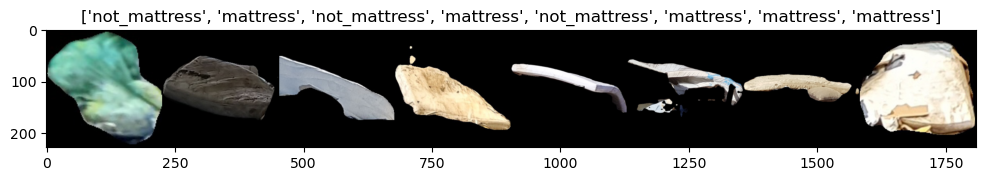

In [16]:
god.show_train_images()

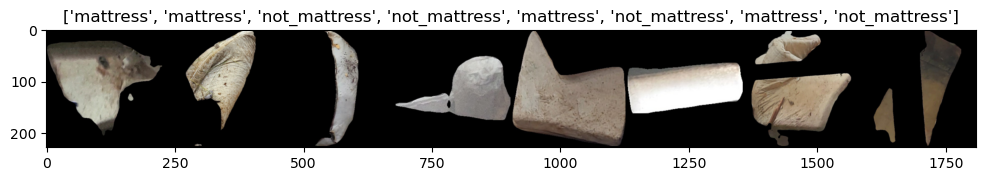

In [17]:
god.show_val_images()

In [18]:
god.run_episodes(3)

  0%|          | 0/3 [00:00<?, ?it/s]


 ===== Episode Nr 1 =====


  0%|          | 0/3 [00:00<?, ?it/s]

Output()

Multi Episode Results at Episode 1:

  val_accuracy:
    best_epoch_mean: 0.69643
    best_epoch_mean_nr: 2
    best_epoch_mean_std: nan
    best_epoch_mean_values: [0.69643]

 ===== Episode Nr 2 =====


  0%|          | 0/3 [00:00<?, ?it/s]

Output()

Multi Episode Results at Episode 2:

  val_accuracy:
    best_epoch_mean: 0.70536
    best_epoch_mean_nr: 3
    best_epoch_mean_std: 0.01263
    best_epoch_mean_values: [0.69643, 0.71429]

 ===== Episode Nr 3 =====


  0%|          | 0/3 [00:00<?, ?it/s]

Output()

Multi Episode Results at Episode 3:

  val_accuracy:
    best_epoch_mean: 0.69643
    best_epoch_mean_nr: 1
    best_epoch_mean_std: 0.03093
    best_epoch_mean_values: [0.66071, 0.71429, 0.71429]


In [ ]:
god.save_results()

# OLD

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -u 1e-3 -f one_episode -f one_epoch -f one_batch -f god.after_batch -f MetricUpdates.update_after_batch_metrics -f god.metrics['train']['train_accuracy']['object'].after_batch -f god.metrics['train']['train_loss']['object'].after_batch -f god.metrics['val']['val_accuracy']['object'].after_batch -f god.metrics['val']['val_loss']['object'].after_batch god.one_episode()


 ===== Episode Nr 2 =====


  0%|          | 0/15 [00:00<?, ?it/s]

*** KeyboardInterrupt exception caught in code being profiled.Timer unit: 0.001 s

Total time: 0.00567974 s
File: /home/ppt/nbs/ba/ppt/util_lib/exp/Metrics.py
Function: update_after_batch_metrics at line 136

Line #      Hits         Time  Per Hit   % Time  Line Contents
   136                                               def update_after_batch_metrics(god):
   137        84          0.1      0.0      2.5          for metric_dict in god.metrics[god.state['phase']].values():
   138        84          5.5      0.1     97.5              metric_dict['object'].after_batch()

Total time: 0.00252165 s
File: /home/ppt/nbs/ba/ppt/util_lib/exp/Metrics.py
Function: after_batch at line 206

Line #      Hits         Time  Per Hit   % Time  Line Contents
   206                                               def after_batch(self):
   207        42          0.0      0.0      1.8          pred, yb = self.god.state['pred'], self.god.state['yb']
   208        42          2.4      0.1     93.9          lo

In [ ]:
%lprun -u 1e-3 -f one_episode -f one_epoch -f one_batch -f god.after_batch -f MetricUpdates.update_after_batch_metrics -f god.metrics['train']['train_accuracy']['object'].after_batch -f god.metrics['train']['train_loss']['object'].after_batch -f god.metrics['val']['val_accuracy']['object'].after_batch -f god.metrics['val']['val_loss']['object'].after_batch god.one_episode()


 ===== Episode Nr 3 =====


  0%|          | 0/15 [00:00<?, ?it/s]

*** KeyboardInterrupt exception caught in code being profiled.Timer unit: 0.001 s

Total time: 0.00392516 s
File: /home/ppt/nbs/ba/ppt/util_lib/exp/Metrics.py
Function: update_after_batch_metrics at line 136

Line #      Hits         Time  Per Hit   % Time  Line Contents
   136                                               def update_after_batch_metrics(god):
   137        60          0.1      0.0      2.0          for metric_dict in god.metrics[god.state['phase']].values():
   138        60          3.8      0.1     98.0              metric_dict['object'].after_batch()

Total time: 0.0019059 s
File: /home/ppt/nbs/ba/ppt/util_lib/exp/Metrics.py
Function: after_batch at line 206

Line #      Hits         Time  Per Hit   % Time  Line Contents
   206                                               def after_batch(self):
   207        30          0.0      0.0      1.4          pred, yb = self.god.state['pred'], self.god.state['yb']
   208        30          1.8      0.1     92.4          los

#### Export

In [ ]:
!python _notebook2script.py 00_GodClass.ipynb